# Project — Part IV (Dynamic Hedging)

Suppose $S_0 = \$100$, $\sigma = 0.2$, $r = 5\%$, $T = \frac{1}{12}$ year, i.e. 1 month, and 
$K = \$100$. Use a Black-Scholes model to simulate the stock price. Suppose we 
sell this at-the-money call option, and we hedge $N$ times during the life of the 
call option. Assume there are 21 trading days over the month.

The dynamic hedging strategy for an option is

$C_t = \phi_t S_t - \psi_t B_t$

where

$\phi_t = \frac{\partial C}{\partial S} = \Phi\left(\frac{\log(\frac{S_t}{K}) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}\right)$

and

$\psi_t B_t = -Ke^{-r(T-t)}\Phi\left(\frac{\log(\frac{S_t}{K}) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}\right)$

Work out the hedging error of the dynamic delta hedging strategy by comparing the replicated position based on $\phi$ and $\psi$ with the final call option payoff at maturity. Use 50,000 paths in your simulation, and plot the histogram of the hedging error for $N = 21$ and $N = 84$.

## Required Libraries


In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("classic")

## Plotting Setup

In [13]:
def setup_plot_style():
    """Set up the plotting style for consistent visualizations"""
    plt.rcParams['figure.figsize'] = [12, 8]
    # plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

def plot_hedging_process(T, process_data, steps):
    """Plot the hedging process with academic color scheme and improved visualization"""
    days = T * 365

    # Define academic color scheme
    # navy_blue = "#002147"      # Oxford Blue
    navy_blue = "#000000"  # Black

    # burnt_orange = "#8B4513"   # Saddle Brown / Academic Orange
    burnt_orange = "#d20000"

    # Set style for academic presentation
    plt.style.use('default')

    # Create figure with GridSpec for better control
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # Define plot configurations
    plots = [
        ('Stock Price', process_data['stock_price'], gs[0, 0]),
        ('Delta', process_data['delta'], gs[0, 1]),
        ('Stock Holding', process_data['stock_holding'], gs[1, 0]),
        ('Bond Holding', process_data['bond_holding'], gs[1, 1]),
        ('Hedged Portfolio', process_data['hedged_portfolio'], gs[2, 0]),
    ]

    # Create individual plots with consistent academic styling
    for title, data, position in plots:
        ax = fig.add_subplot(position)

        # Plot line with academic blue
        ax.plot(days, data,
               color=navy_blue,
               linewidth=1,
               marker='x' if steps <= 60 else None,
               markersize=4,
               markerfacecolor=navy_blue,
               markeredgecolor=navy_blue)

        # Customize grid
        ax.grid(True, linestyle='--', alpha=0.3)

        # Set title and labels with academic font
        ax.set_title(title, fontsize=12, pad=10, fontweight='bold')
        ax.set_xlabel('Days', fontsize=10)

        # Customize spines
        for spine in ax.spines.values():
            spine.set_linewidth(1)

        # Customize ticks
        ax.tick_params(axis='both', direction='out', length=6, width=1)

    # Create hedging error plot
    ax_error = fig.add_subplot(gs[2, 1])

    # Plot with academic colors
    ax_error.plot(days, process_data['stock_hedge_error'],
                label='Stock Hedge Error',
                color=navy_blue,
                linewidth=1,
                marker='o' if steps <= 60 else None,
                markersize=4,
                markerfacecolor=navy_blue,
                markeredgecolor=navy_blue)

    ax_error.plot(days, process_data['bond_hedge_error'],
                label='Bond Hedge Error',
                color=burnt_orange,
                linewidth=1,
                marker='x' if steps <= 60 else None,
                markersize=4,
                markerfacecolor=burnt_orange,
                markeredgecolor=burnt_orange)

    # Customize grid for error plot
    ax_error.grid(True, linestyle='--', alpha=0.3)

    # Customize legend
    ax_error.legend(frameon=True,
                   fancybox=False,
                   edgecolor='black',
                   fontsize=10)

    # Set title and labels
    ax_error.set_title('Hedging Error', fontsize=12, pad=10, fontweight='bold')
    ax_error.set_xlabel('Days', fontsize=10)

    # Customize spines for error plot
    for spine in ax_error.spines.values():
        spine.set_linewidth(1)

    # Customize ticks for error plot
    ax_error.tick_params(axis='both', direction='out', length=6, width=1)

    # Add main title
    fig.suptitle(f"Black-Scholes Hedging Process (N = {steps} steps)",
                fontsize=14,
                y=0.95,
                fontweight='bold')

    return fig


def plot_pl_distribution(pl_results):
    """Plot P&L distribution with academic styling and improved visualization"""
    fig, axes = plt.subplots(1, len(pl_results), figsize=(15, 6))

    # Define a darker red color
    dark_red = '#d20000'  # Dark red / burgundy

    for i, (steps, final_PL, stats) in enumerate(pl_results):
        ax = axes[i] if len(pl_results) > 1 else axes

        # Check if final_PL is not empty
        if len(final_PL) == 0:
            print(f"No data to plot for step {steps}.")
            continue

        # Calculate histogram with fixed x-range
        counts, bins, _ = ax.hist(
            final_PL,
            bins=30,
            weights=np.ones(len(final_PL)) / len(final_PL) * 100,
            color=dark_red,
            alpha=1.0,
            edgecolor=dark_red,
            linewidth=0.5,
            range=(-1.5, 1.5)  # Fixed range as requested
        )

        # Set y-axis limits and ticks
        max_count = np.max(counts)
        y_max = np.ceil(max_count / 5) * 5  # Round up to nearest 5
        ax.set_ylim(0, y_max)

        # Create major ticks at intervals of 5
        y_major_ticks = np.arange(0, y_max + 1, 5)
        ax.set_yticks(y_major_ticks)

        # Create minor ticks at intervals of 1
        y_minor_ticks = np.arange(0, y_max + 1, 1)
        ax.set_yticks(y_minor_ticks, minor=True)

        # Set x-axis limits and ticks
        ax.set_xlim(-1.5, 1.5)

        # Create major x-ticks at intervals of 0.5
        x_major_ticks = np.arange(-1.5, 1.6, 0.5)
        ax.set_xticks(x_major_ticks)

        # Create minor x-ticks at intervals of 0.1
        x_minor_ticks = np.arange(-1.5, 1.6, 0.1)
        ax.set_xticks(x_minor_ticks, minor=True)

        # Customize tick parameters consistently for both axes
        ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=8)
        ax.tick_params(axis='both', which='minor', direction='out', length=3, width=1)

        # Keep all spines visible and set their properties
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)

        # Customize axis labels with bold font
        ax.set_xlabel('Final Profit/Loss', fontsize=12, labelpad=10, fontweight='bold')
        ax.set_ylabel('Frequency (out of 100%)', fontsize=12, labelpad=10, fontweight='bold')

        # Format axis fonts and styles
        ax.tick_params(axis='both', which='major', labelsize=12)

        # Set bold title
        ax.set_title(f'Histogram (N = {steps}) Rebalancing Steps',
                    fontsize=14,
                    pad=15,
                    fontweight='bold')

        # Add statistics with improved formatting
        stats_text = (
            f"$\\boldsymbol{{\\mu}}$ = {stats['mean']:.2f}\n"
            f"$\\boldsymbol{{\\sigma}}$ = {stats['std']:.2f}\n"
            f"$\\boldsymbol{{\\mathrm{{SD/Premium}}}}$ = {stats['sd_premium']:.2f}"
        )

        ax.text(
            0.95,
            0.95,
            stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', pad=5),
            fontsize=12
        )

        # Add grid with light lines
        ax.grid(True, which='major', linestyle='--', alpha=0.3)
        ax.grid(True, which='minor', linestyle=':', alpha=0.15)

    plt.tight_layout()
    return fig


## Black-Scholes Implementation Functions

In [14]:

def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

def simulate_brownian_motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)), np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

def calculate_hedging_error(S0, K, r, sigma, T, t, x):
    S = pd.DataFrame(S0 * np.exp((r-sigma**2/2)*t + sigma*x))
    phi_values = pd.DataFrame(phi(S, K, r, sigma, T-t))
    psib_values = pd.DataFrame(psi_Bt(S, K, r, sigma, T-t))

    hedging_error = pd.DataFrame(
        phi_values.values[:,:-1] * np.diff(S) +
        psib_values.values[:,:-1] * r * (T/len(t))
    )
    hedging_error['Sum'] = hedging_error.apply(np.sum, axis=1)
    payoff = np.maximum(S-K, 0)
    call_option = black_scholes_call(S0, K, r, sigma, T)
    final_PL = hedging_error['Sum'].values + call_option - payoff.iloc[:,-1]
    return final_PL


In [15]:
def create_hedging_dataframe(process_data, T):
    """Create a DataFrame of the hedging process."""
    df = pd.DataFrame({
        'Time': T,
        'Stock Price': process_data['stock_price'],
        'Delta': process_data['delta'],
        'Stock Holding': process_data['stock_holding'],
        'Bond Holding': process_data['bond_holding'],
        'Hedged Portfolio': process_data['hedged_portfolio'],
        'Stock Hedge Error': process_data['stock_hedge_error'],
        'Bond Hedge Error': process_data['bond_hedge_error']
    })
    df.set_index('Time', inplace=True)
    return df


## Hedging Error Simulation

C:\Users\fwoit\AppData\Local\Temp\ipykernel_32960\3185168197.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
C:\Users\fwoit\AppData\Local\Temp\ipykernel_32960\3185168197.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


          Stock Price     Delta  Stock Holding  Bond Holding  \
Time                                                           
0.000000   100.000000  0.540239      54.023918    -51.511851   
0.003968   100.124929  0.548060      54.874420    -52.359883   
0.007937    99.113103  0.473644      46.944294    -45.013326   
0.011905    98.264919  0.407527      40.045593    -38.553753   
0.015873    96.624925  0.284327      27.473037    -26.607773   

          Hedged Portfolio  Stock Hedge Error  Bond Hedge Error  
Time                                                             
0.000000        105.535768           0.000000          0.000000  
0.003968        107.234303          -0.783010          0.837811  
0.007937         91.957620           7.375584         -7.356947  
0.011905         78.599346           6.496965         -6.468505  
0.015873         54.080810          11.904214        -11.953630  


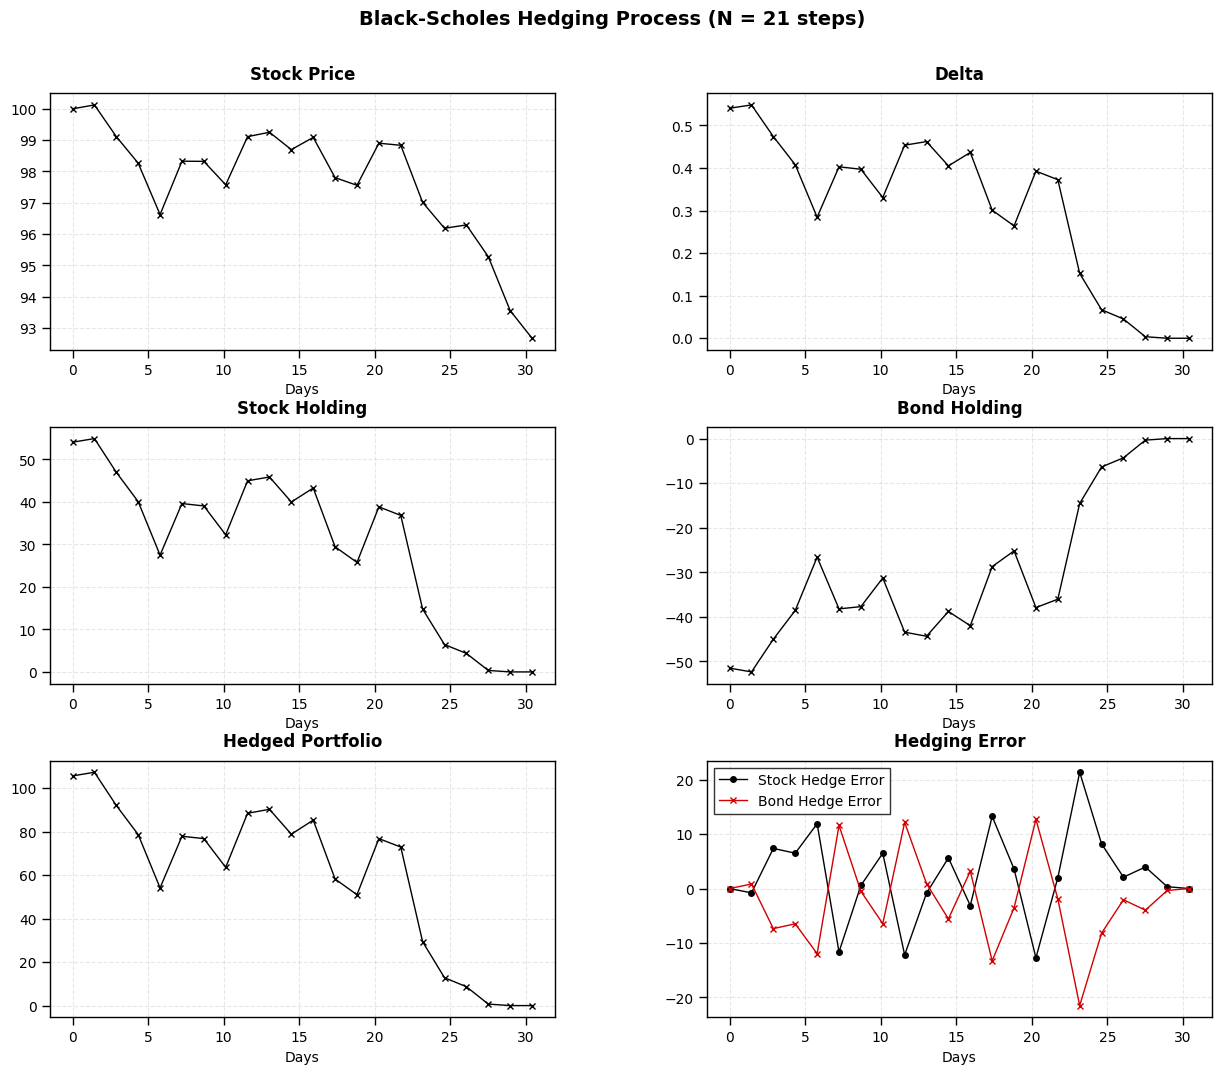

{'mean': 0.01, 'std': 0.43, 'sd_premium': 17.0}

Results for N = 21:
Mean P&L: 0.01
Standard Deviation: 0.43
SD as % of option premium: 17.0%
          Stock Price     Delta  Stock Holding  Bond Holding  \
Time                                                           
0.000000   100.000000  0.540239      54.023918    -51.511851   
0.000992   100.468276  0.572145      57.482415    -54.726168   
0.001984   101.561266  0.644833      65.490101    -62.084774   
0.002976   101.575404  0.646142      65.632111    -62.233927   
0.003968   101.994524  0.673324      68.675351    -65.016888   

          Hedged Portfolio  Stock Hedge Error  Bond Hedge Error  
Time                                                             
0.000000        105.535768           0.000000          0.000000  
0.000992        112.208583          -3.205516          3.211763  
0.001984        127.574876          -7.382338          7.355891  
0.002976        127.866038          -0.132893          0.146073  
0.003968     

C:\Users\fwoit\AppData\Local\Temp\ipykernel_32960\3185168197.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
C:\Users\fwoit\AppData\Local\Temp\ipykernel_32960\3185168197.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


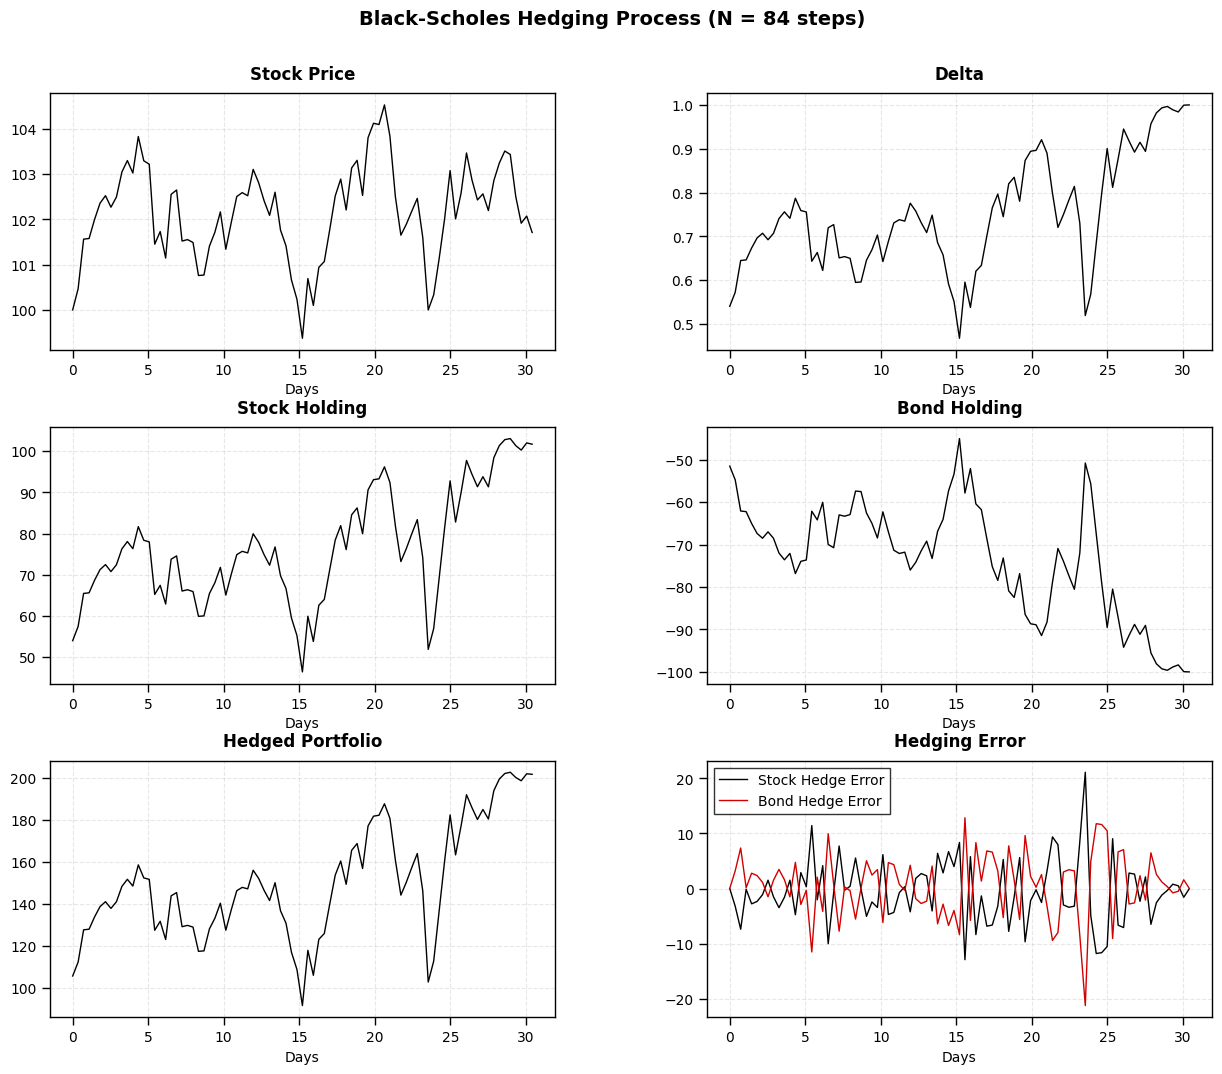

{'mean': 0.0, 'std': 0.22, 'sd_premium': 9.0}

Results for N = 84:
Mean P&L: 0.0
Standard Deviation: 0.22
SD as % of option premium: 9.0%


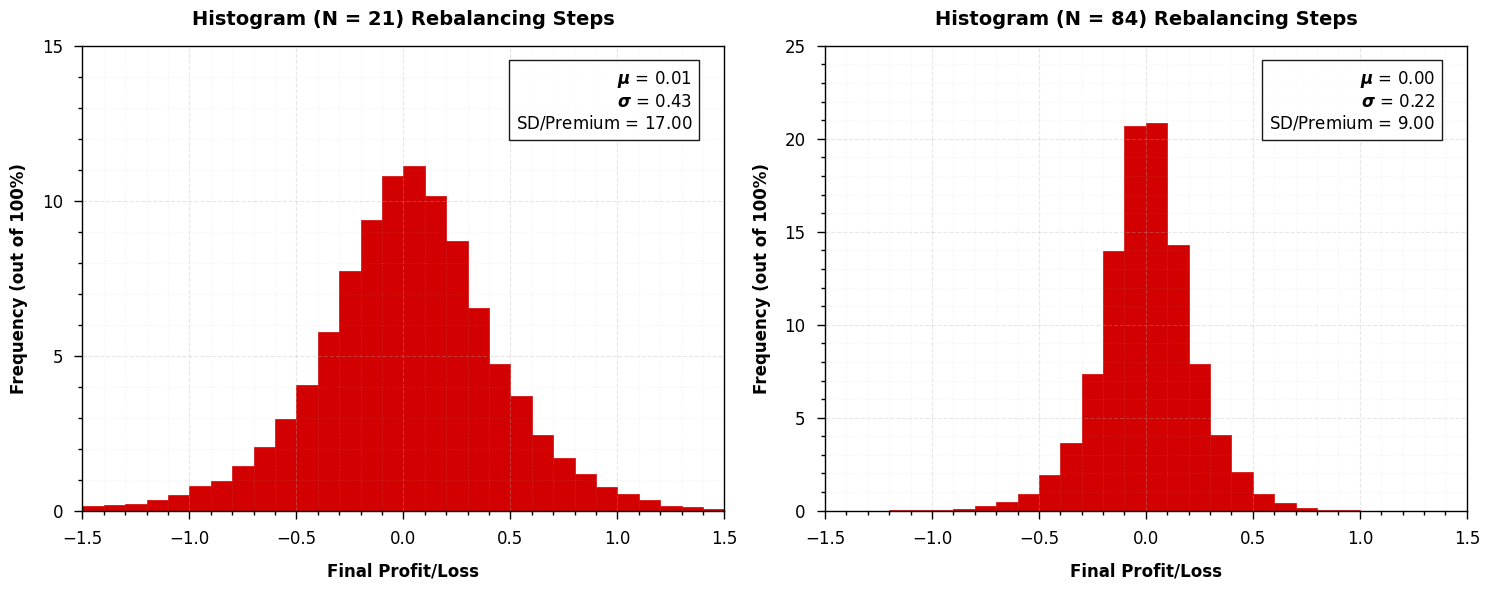

In [17]:

def main():
    # Set up plotting style
    setup_plot_style()

    # Parameters
    r, S0, K = 0.05, 100, 100
    sigma = 0.2
    maturity = 1/12
    paths = 50000
    list_N = [21, 84]

    pl_results = []

    for steps in list_N:
        # Simulate paths
        T, W_T = simulate_brownian_motion(paths, steps, maturity)

        # Calculate hedging process for first path
        dt = maturity / steps
        blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

        # Process data collection
        process_data = {
            'stock_price': blackscholespath,
            'delta': [],
            'stock_holding': [],
            'bond_holding': [],
            'hedged_portfolio': [],
            'stock_hedge_error': [0],
            'bond_hedge_error': [0]
        }

        prev_phi = prev_bond_pos = None

        for t, S_t in zip(T, blackscholespath):
            delta = phi(S_t, K, r, sigma, maturity-t)
            stock_pos = delta * S_t
            bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)

            process_data['delta'].append(delta)
            process_data['stock_holding'].append(stock_pos)
            process_data['bond_holding'].append(bond_pos)
            process_data['hedged_portfolio'].append(stock_pos - bond_pos)

            if prev_phi is not None:
                process_data['stock_hedge_error'].append(prev_phi*S_t - stock_pos)
                process_data['bond_hedge_error'].append(prev_bond_pos*np.exp(r*dt) - bond_pos)

            prev_phi = delta
            prev_bond_pos = bond_pos

        df_hedging = create_hedging_dataframe(process_data, T)
        print(df_hedging.head())

        df_hedging.to_csv(f'hedging_data_N_{steps}.csv')


        # Plot hedging process
        fig_process = plot_hedging_process(T, process_data, steps)
        plt.show()

        # Calculate P&L distribution
        final_PL = calculate_hedging_error(S0, K, r, sigma, maturity, T, W_T)

        # Calculate statistics
        stats = {
            'mean': round(np.mean(final_PL), 2),
            'std': round(np.std(final_PL), 2),
            'sd_premium': round(np.std(final_PL)/black_scholes_call(S0, K, r, sigma, maturity), 2)*100
        }

        print(stats)

        pl_results.append((steps, final_PL, stats))

        # Print statistics
        print(f"\nResults for N = {steps}:")
        print(f"Mean P&L: {stats['mean']}")
        print(f"Standard Deviation: {stats['std']}")
        print(f"SD as % of option premium: {stats['sd_premium']}%")

    # Plot P&L distributions
    fig_pl = plot_pl_distribution(pl_results)
    plt.show()

if __name__ == "__main__":
    main()